In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [2]:
K.set_image_dim_ordering("th")


img_size = 240      #original img size is 240*240
smooth = 0.005 
num_of_aug = 2
num_epoch = 30
pul_seq = 'Flair'
sharp = False       # sharpen filter
LR = 1e-4

num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis+NET, 2 = tumor core,3= original, 4 = ET, 5 = complete tumor
'''
0: other
1: necrosis + NET
2: edema
4: enhancing tumor
5: full tumor
'''

'\n0: other\n1: necrosis + NET\n2: edema\n4: enhancing tumor\n5: full tumor\n'

In [3]:
# function to read all data (training and label) and transform into numpy array
import glob
def create_data(src, mask, label=False, resize=(155,img_size,img_size)):
    files = glob.glob(src + mask, recursive=True)
    r.seed(9)
    r.shuffle(files)    # shuffle patients
    imgs = []
    print('Processing---', mask)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        #img = trans.resize(img, resize, mode='constant')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis and NET
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            if label_num == 3:
                img[img == 3] = 1       # remain GT, design for 2015 data
                
                
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
            img = img.astype('float32')
        for slice in range(60,130):     #choose the slice range
            img_t = img[slice,:,:]
            img_t =img_t.reshape((1,)+img_t.shape)
            img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
            #img_g = augmentation(img_t,num_of_aug)
            for n in range(img_t.shape[0]):
                imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [4]:
#function to read one subject data
def create_data_onesubject_val(src, mask,count, label=False):
    files = glob.glob(src + mask, recursive=True)
    r.seed(9)
    r.shuffle(files)    # shuffle patients
    k = len(files) - count -1
    imgs = []
    file = files[k]
    print('Processing---', mask,'--',file)
    
    img = io.imread(file, plugin='simpleitk')
    #img = trans.resize(img, resize, mode='constant')
    if label:
        if label_num == 5:
            img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
        if label_num == 1:
            img[img != 1] = 0       #only left necrosis
        if label_num == 2:
            img[img == 2] = 0       #turn edema to 0
            img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
        if label_num == 4:
            img[img != 4] = 0       #only left ET
            img[img == 4] = 1
        img = img.astype('float32')
    else:
        img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
        img = img.astype('float32')
    for slice in range(155):     #choose the slice range
        img_t = img[slice,:,:]
        img_t =img_t.reshape((1,)+img_t.shape)
        img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
        #img_g = augmentation(img_t,num_of_aug)
        for n in range(img_t.shape[0]):
            imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [15]:
#read one subject to show slices
count = 106
pul_seq = 'flair'
Flair = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't1ce'
T1c = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't1'
T1 = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't2'
T2 = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
label_num = 5
Label_full = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*seg.nii.gz', count, label=True)
label_num = 2
Label_core = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*seg.nii.gz', count, label=True)
label_num = 4
Label_ET = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*seg.nii.gz', count, label=True)
label_num = 3
Label_all = create_data_onesubject_val('C:/brain_tumor/BRATS2018/HGG/', '**/*seg.nii.gz', count, label=True)

Processing--- **/*flair.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_flair.nii.gz
Processing--- **/*t1ce.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_t1ce.nii.gz
Processing--- **/*t1.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_t1.nii.gz
Processing--- **/*t2.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_t2.nii.gz
Processing--- **/*seg.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- C:/brain_tumor/BRATS2018/HGG\Brats18_CBICA_ASG_1\Brats18_CBICA_ASG_1_seg.nii.gz


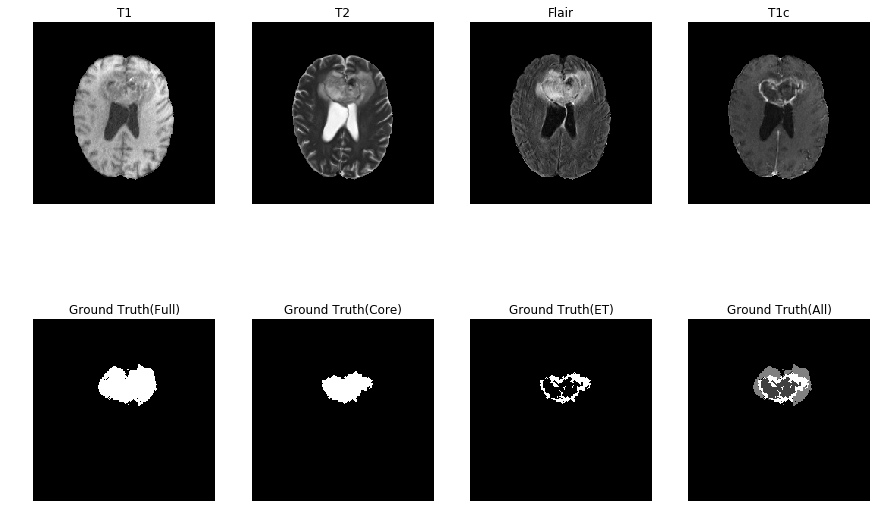

In [18]:
plt.figure(figsize=(15,10))

plt.subplot(241)
plt.title('T1')
plt.axis('off')
plt.imshow(T1[90, 0, :, :],cmap='gray')

plt.subplot(242)
plt.title('T2')
plt.axis('off')
plt.imshow(T2[90, 0, :, :],cmap='gray')
    
plt.subplot(243)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair[90, 0, :, :],cmap='gray')

plt.subplot(244)
plt.title('T1c')
plt.axis('off')
plt.imshow(T1c[90, 0, :, :],cmap='gray')

plt.subplot(245)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(Label_full[90, 0, :, :],cmap='gray')

plt.subplot(246)
plt.title('Ground Truth(Core)')
plt.axis('off')
plt.imshow(Label_core[90, 0, :, :],cmap='gray')

plt.subplot(247)
plt.title('Ground Truth(ET)')
plt.axis('off')
plt.imshow(Label_ET[90, 0, :, :],cmap='gray')

plt.subplot(248)
plt.title('Ground Truth(All)')
plt.axis('off')
plt.imshow(Label_all[90, 0, :, :],cmap='gray')

plt.show()

In [41]:
# our U-net for full tumor segmentation
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    inputs = Input((2, img_size, img_size))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=LR), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [42]:
model = unet_model()
model.load_weights('C:/brain_tumor/BRATS2018/weights-full-best.h5')
#history = model.fit(x, y, batch_size=16, validation_split=0,validation_data = (val_x,val_y) ,epochs = 40,callbacks = callbacks_list ,verbose=1, shuffle=True)

In [23]:
#using Flair and T2 as input for full tumor segmentation
x = np.zeros((1,2,240,240),np.float32)
x[:,:1,:,:] = Flair[89:90,:,:,:]   #choosing 90th slice as example
x[:,1:,:,:] = T2[89:90,:,:,:] 

pred_full = model.predict(x)

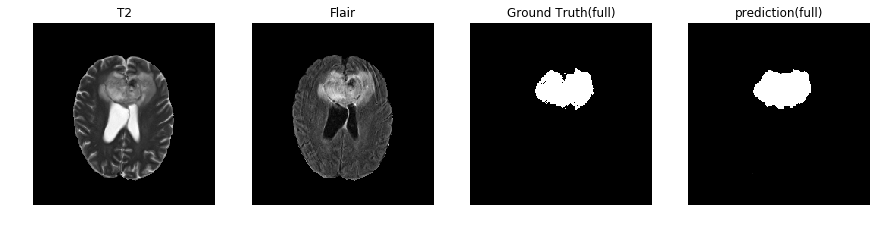

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('T2')
plt.axis('off')
plt.imshow(T2[90, 0, :, :],cmap='gray')
    
plt.subplot(142)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair[90, 0, :, :],cmap='gray')

plt.subplot(143)
plt.title('Ground Truth(full)')
plt.axis('off')
plt.imshow(Label_full[90, 0, :, :],cmap='gray')

plt.subplot(144)
plt.title('prediction(full)')
plt.axis('off')
plt.imshow(pred_full[0, 0, :, :],cmap='gray')

plt.show()

In [51]:
# cropping function
def crop_tumor_tissue(x, pred, size):   #   input: x:T1c image , pred:prediction of full tumor ,size default  64x64
    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    # threshold
    p_tmp[p_tmp !=1] = 0
    #get middle point from prediction of full tumor
    index_xy = np.where(p_tmp==1)   # get all the axial of pixel which value is 1

    if index_xy[0].shape[0] == 0:   #skip when no tumor
        return [],[]
        
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2 
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8
        
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  #64x64
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        #x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)] = 0
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  #64x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        #x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)] = 0
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        #x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y) : int(center_y + size)] = 0
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:  #128x64       
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        #x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)] = 0
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        #x[:,int(center_x) : int(center_x + size),int(center_y - size/2) : int(center_y + size/2)] = 0
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  #128x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        #x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)] = 0
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        #x[:,int(center_x) : int(center_x + size),int(center_y - size) : int(center_y)] = 0
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        #x[:,int(center_x - size) : int(center_x),int(center_y) : int(center_y + size)] = 0
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        #x[:,int(center_x) : int(center_x + size),int(center_y) : int(center_y + size)] = 0
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy   #(y,x)

In [52]:
# cropping prediction part for tumor core and enhancing tumor segmentation
crop , li = crop_tumor_tissue(T1c[90,:,:,:],pred_full[0,:,:,:],64)

In [53]:
crop.shape[0]

2

In [43]:
# U-net for Tumor core and ET
img_size_nec = 64
    
def unet_model_nec3():
    inputs = Input((1, img_size_nec, img_size_nec))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    #conv4 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool3)
    #conv4 = Conv2D(256, (3, 3), activation='relu', padding='same') (conv4)
    #pool4 = MaxPooling2D(pool_size=(2, 2)) (conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    #up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (conv5)
    #up6 = concatenate([up6, conv4])
    #conv6 = Conv2D(256, (3, 3), activation='relu', padding='same') (up6)
    #conv6 = Conv2D(256, (3, 3), activation='relu', padding='same') (conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=LR), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [46]:
model_core = unet_model_nec3()
model_core.load_weights('C:/brain_tumor/BRATS2018/weights-core-best.h5')
model_ET = unet_model_nec3()
model_ET.load_weights('C:/brain_tumor/BRATS2018/weights-ET-best.h5')

In [55]:
pred_core = model_core.predict(crop)
pred_ET = model_ET.predict(crop)

In [56]:
def paint_color_algo(pred_full, pred_core , pred_ET , li):   #input image is [n,1, y, x]
    # first put the pred_full on T1c
    pred_full[pred_full > 0.2] = 2      #240x240
    pred_full[pred_full != 2] = 0
    pred_core[pred_core > 0.2] = 1      #64x64
    pred_core[pred_core != 1] = 0
    pred_ET[pred_ET > 0.2] = 4          #64x64
    pred_ET[pred_ET != 4] = 0

    total = np.zeros((1,240,240),np.float32)  
    total[:,:,:] = pred_full[:,:,:]
    for i in range(pred_core.shape[0]):
        for j in range(64):
            for k in range(64):
                if pred_core[i,0,j,k] != 0 and pred_full[0,li[i][0]+j,li[i][1]+k] !=0:
                    total[0,li[i][0]+j,li[i][1]+k] = pred_core[i,0,j,k]
                if pred_ET[i,0,j,k] != 0 and pred_full[0,li[i][0]+j,li[i][1]+k] !=0:
                    total[0,li[i][0]+j,li[i][1]+k] = pred_ET[i,0,j,k]
                
    
    
    return total

In [58]:
tmp = paint_color_algo(pred_full[0,:,:,:], pred_core, pred_ET, li)

core = np.zeros((1,240,240),np.float32)
ET = np.zeros((1,240,240),np.float32)
core[:,:,:] = tmp[:,:,:]
ET[:,:,:] = tmp[:,:,:]
core[core == 4] = 1
core[core != 1] = 0
ET[ET != 4] = 0

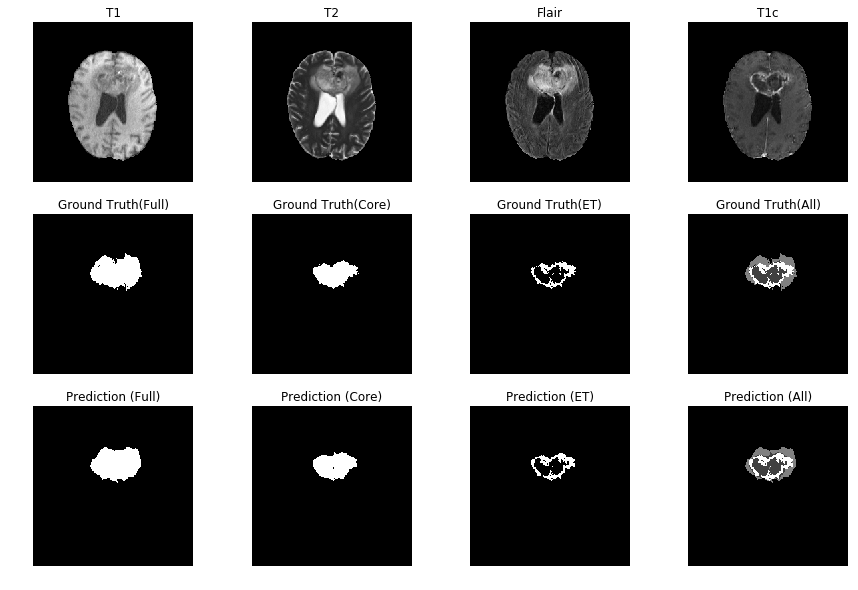

In [59]:
plt.figure(figsize=(15,10))

plt.subplot(341)
plt.title('T1')
plt.axis('off')
plt.imshow(T1[90, 0, :, :],cmap='gray')

plt.subplot(342)
plt.title('T2')
plt.axis('off')
plt.imshow(T2[90, 0, :, :],cmap='gray')
    
plt.subplot(343)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair[90, 0, :, :],cmap='gray')

plt.subplot(344)
plt.title('T1c')
plt.axis('off')
plt.imshow(T1c[90, 0, :, :],cmap='gray')

plt.subplot(345)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(Label_full[90, 0, :, :],cmap='gray')

plt.subplot(346)
plt.title('Ground Truth(Core)')
plt.axis('off')
plt.imshow(Label_core[90, 0, :, :],cmap='gray')

plt.subplot(347)
plt.title('Ground Truth(ET)')
plt.axis('off')
plt.imshow(Label_ET[90, 0, :, :],cmap='gray')

plt.subplot(348)
plt.title('Ground Truth(All)')
plt.axis('off')
plt.imshow(Label_all[90, 0, :, :],cmap='gray')

plt.subplot(349)
plt.title('Prediction (Full)')
plt.axis('off')
plt.imshow(pred_full[0, 0, :, :],cmap='gray')

plt.subplot(3,4,10)
plt.title('Prediction (Core)')
plt.axis('off')
plt.imshow(core[0, :, :],cmap='gray')

plt.subplot(3,4,11)
plt.title('Prediction (ET)')
plt.axis('off')
plt.imshow(ET[0, :, :],cmap='gray')

plt.subplot(3,4,12)
plt.title('Prediction (All)')
plt.axis('off')
plt.imshow(tmp[0, :, :],cmap='gray')

plt.show()